In [2]:
from outlaw.nb_util import setup_nb
setup_nb()

In [3]:
import outlaw.inla as inla
import outlaw.quad as quad
import outlaw.berry as berry
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import scipy.stats
import jax
import jax.numpy as jnp
import numpyro.infer
import numpyro.distributions as dist

/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N = 100
data = berry.figure2_data(N=N)

In [5]:
sig2_rule = quad.log_gauss_rule(15, 1e-6, 1e3)
ops = berry.optimized(sig2_rule.pts)
p_ex = dict(sig2=np.array([nan]), theta=np.zeros(4))
lj_f = berry.log_joint(4)
ops = inla.from_log_joint(lj_f, p_ex)
p_pinned = dict(sig2=sig2_rule.pts, theta=None)
logpost, x_max, hess_info, iters = jax.vmap(
    ops.laplace_logpost, in_axes=(None, None, 0)
)(jnp.zeros((15, 4)), p_pinned, data)
sig2_post = inla.exp_and_normalize(logpost, sig2_rule.wts[None], axis=1)

In [6]:
invv = jax.jit(jax.vmap(jax.vmap(ops.invert)))
inv_hess = invv(hess_info)

### Compare against full laplace

In [7]:
arm_logpost_f = jax.jit(
    jax.vmap(
        jax.vmap(
            ops.cond_laplace_logpost, in_axes=(0, 0, None, 0, 0, None, None)
        ),
        in_axes=(None, None, None, None, 0, None, None),
    ),
    static_argnums=(5, 6),
)
arm_post = []
arm_cx = []
for arm_idx in range(4):
    cx, wts = inla.gauss_hermite_grid(
        x_max, inv_hess[..., arm_idx, :], arm_idx, n=25
    )
    arm_logpost = arm_logpost_f(
        x_max, inv_hess[:, :, arm_idx], p_pinned, data, cx, arm_idx, True
    )
    arm_cx.append(cx)
    arm_post.append(inla.exp_and_normalize(arm_logpost, wts, axis=0))
arm_cx = jnp.array(arm_cx)
arm_post = jnp.array(arm_post)

### Correlation coefficients from the conditional mean

Equation 14 from the Rue paper. 
$$
\frac{E_{\tilde{\pi}_G}(x_j|x_i) - \mu_j(\theta)}{\sigma_j(\theta)} = a_{ij} \frac{x_i - \mu_i(\theta)}{\sigma_i(\theta)}
$$
Understanding this:

Both sides are standardized values. The coefficient $a_{ij}$ that relates the two sides is effectively how much the conditional expectation of $x_j$ moves given a unit movement of $x_i$. In some sense, this is how tightly coupled the two variables are.

The values of $a_{ij}$ are correlation coefficients. Given a known covariance matrix $\Sigma_{ij}$, the conditional expectation is:

$$
E_{\tilde{\pi}_G}(x_j|x_i) = \mu_j + \Sigma_{ij} \bigg(\frac{x - \mu_i}{\Sigma_{ii}}\bigg)
$$

Also: $\sigma_i = \sqrt{\Sigma_{ii}}$

Putting the two above equations together, we can write $a_{ij}$ in terms of $\Sigma$:

$$
a_{ij} = \frac{\Sigma_{ij}}{\sigma_i \sigma_j}
$$

This is the definition of a correlation coefficient.

In [8]:
cov = -inv_hess[0,:]
std_dev = np.sqrt(np.diagonal(cov, axis1=-2, axis2=-1))
a_ij = cov / np.einsum('...i,...j->...ij', std_dev, std_dev)

In [9]:
cond_mu = []
cond_hess = []
for armi_idx in range(4):
    cond_mu.append(inla.mvn_conditional_meanv(x_max[0], inv_hess[0, :, armi_idx], x_max[0, :, armi_idx] * 0, armi_idx))
    cond_hess.append(ops.reduced_hessv(cond_mu[-1], p_pinned, data, armi_idx))
cond_mu = jnp.array(cond_mu)
cond_hess = jnp.array(cond_hess)

for i in range(4):
    mu = x_max[i,:]
    cmu = cond_mu[i,:]
    std_dev = np.sqrt(np.diagonal(-inv_hess[0,:], axis1=-2, axis2=-1))
    xs = (0 - mu[..., i]) / std_dev[..., i]
    a_ij_correct = ((cmu - mu) / std_dev) / xs[:, None]
    np.testing.assert_almost_equal(a_ij[:,i].to_py(), a_ij_correct.to_py())

### Third derivative facts.

- The third derivative of a Gaussian density is zero! (by definition)
- Thus, in a typical INLA model, when conditioning on the hyperparameter, the third derivative is composed entirely of the log likelihood of the data conditional on the latent variables.
- In a typical INLA model, the data are related to individual Gaussian latent variables.
- Therefore, the third derivative tensor is actually diagonal because all interactions are limited to zeroth/first/second order effects.

This is why the equation in Rue refers to $\pi(y_j|x_j, \theta)$ 

<img src="2022-07-19-19-00-44.png" width="400"/>

### Denominator expansion

In this section, we use automatic differentiation to confirm the formulas in Rue section 3.2.3. We start with the denominator expression from equations (19) and (20). Why am I using automatic differentiation to do this? Because getting the formulas right was hard and I wasn't confident they were correct. The comparison against the AD calculation makes me confident that the code is correctly the formulas.

In [10]:
armi_idx = 0
def denom(x_i, x_max, inv_hess, p_pinned, data):
    cond_mu = inla.mvn_conditional_mean(x_max, inv_hess, x_i, armi_idx)
    H = ops.reduced_hessv(cond_mu[None], dict(sig2=p_pinned['sig2'][None], theta=None), data, armi_idx)[0]
    # The negative sign is because gamma1 comes from the denominator, see eqtn 21 in Rue.
    return -0.5 * jnp.linalg.slogdet(H[None])[1][0]
denom_f = jax.jit(jax.vmap(jax.grad(denom), in_axes=(0,0,0,0,None)))
denom_jax = denom_f(x_max[0,:,0], x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])

In [11]:
# d3 is the third derivative of the data likelihood with respect to the latent variables
def lj_f0(x_i, x_max, sig2, data, i):
    theta = x_max.at[i].set(x_i)
    return ops.log_jointv(theta[None], dict(sig2=sig2[None], theta=None), data)[0]
d3_f = jax.jit(
    jax.vmap(jax.grad(jax.grad(jax.grad(lj_f0))), in_axes=(0, 0, 0, None, None)),
    static_argnums=(4,),
)
d3 = []
for i in range(4):
    d3.append(d3_f(x_max[0, :, i], x_max[0], sig2_rule.pts, data[0], i))
d3 = np.array(d3).T
d3

array([[-1.89317814, -1.8931785 , -3.31306573, -3.31306637],
       [-1.89317702, -1.89317763, -3.31306651, -3.31306759],
       [-1.89317284, -1.89317438, -3.31306941, -3.31307211],
       [-1.89315476, -1.89316033, -3.31308196, -3.3130917 ],
       [-1.89305707, -1.89308441, -3.31314966, -3.31319737],
       [-1.89241073, -1.89258267, -3.3135938 , -3.31388976],
       [-1.88736538, -1.88869874, -3.31685354, -3.3189242 ],
       [-1.83994247, -1.85377413, -3.33718988, -3.34773598],
       [-1.44746037, -1.58526149, -3.36721112, -3.34262648],
       [-0.62280055, -1.07571967, -3.30717799, -3.17308978],
       [-0.18667765, -0.88631817, -3.26306158, -3.08835179],
       [-0.05578223, -0.85877986, -3.25130248, -3.06788028],
       [-0.02019243, -0.85586443, -3.24849263, -3.06314232],
       [-0.00963231, -0.85547018, -3.24777735, -3.06194807],
       [-0.00627686, -0.85534518, -3.24758785, -3.06163141]])

In [12]:
# The analytical third derivative is going to be a bit faster computationally.
def d3_analytical(theta, data):
    y = data[..., 0]
    n = data[..., 1]
    exp_theta_adj = jnp.exp(theta + berry.logit_p1)
    C = 1 / (exp_theta_adj + 1)
    # return -n * C ** 2 * exp_theta_adj
    dCdt = -exp_theta_adj * C ** 2
    return -n * C ** 2 * exp_theta_adj * (-2 * exp_theta_adj * C + 1)
d3a = jax.vmap(d3_analytical, in_axes=(0,None))(x_max[0, :], data[0])
d3 - d3a

DeviceArray([[-6.66133815e-16,  0.00000000e+00,  4.44089210e-16,  8.88178420e-16],
             [ 2.22044605e-16,  6.66133815e-16, -8.88178420e-16,  8.88178420e-16],
             [-2.22044605e-16,  4.44089210e-16, -8.88178420e-16,  0.00000000e+00],
             [-2.22044605e-16,  2.22044605e-16, -4.44089210e-16,  1.33226763e-15],
             [-6.66133815e-16,  2.22044605e-16,  0.00000000e+00, -4.44089210e-16],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.44089210e-16],
             [ 4.44089210e-16,  4.44089210e-16,  0.00000000e+00, -1.33226763e-15],
             [-2.22044605e-16,  0.00000000e+00,  0.00000000e+00,  8.88178420e-16],
             [ 2.22044605e-16,  0.00000000e+00,  1.33226763e-15,  0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00, -4.44089210e-16,  0.00000000e+00],
             [-2.77555756e-17,  0.00000000e+00, -4.44089210e-16,  2.22044605e-15],
             [ 0.00000000e+00,  1.11022302e-16, -8.88178420e-16,  0.00000000e+00],
    

Why does Rue calculate the variance of the dependent variables in terms of the correlations? Because then we don't need to construct and invert the reduced hessian matrices where the marginal arm has been removed.

<img src="2022-08-11-15-18-22.png" width="400px"/>

In [13]:
nonarm_idx = jnp.setdiff1d(jnp.arange(4), armi_idx).to_py()

# Version 1: calculating the variance directly by invert the reduced 3x3 hessian matrix.
# reduced_hess = np.delete(np.delete(hess_info, armi_idx, axis=-2), armi_idx, axis=-1)
# T = np.linalg.inv(reduced_hess)
# cond_var = np.diagonal(-T[0], axis1=-2, axis2=-1)


# Version 2: calculating the variance by using the full 4x4 inverse hessian
# matrix and then mutliplying by the correlation coefficients. This is faster
# because it doesn't require any extra matrix inversions. 
corr_xi_xj = inv_hess[0, :, armi_idx, :][:, nonarm_idx] / (
    std_dev[:, nonarm_idx] * std_dev[:, None, armi_idx]
)
cond_var = std_dev[:, nonarm_idx] ** 2 * (1 - (corr_xi_xj) ** 2)


**`gamma1`** here is the variable defined in equation (21) in Rue. The explicit calculation matches the autodiff calculation to 16 digits.

In [14]:
gamma1 = (
    0.5
    * np.sum(
        cond_var
        * d3[:, nonarm_idx]
        * a_ij[:, armi_idx, nonarm_idx]
        * std_dev[:, nonarm_idx],
        axis=1,
    )
    / std_dev[:, armi_idx]
)
gamma1 / denom_jax, gamma1 - denom_jax

(DeviceArray([1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        ,
              1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        ,
              0.99999997], dtype=float64),
 DeviceArray([-1.03393924e-16,  3.77573407e-17,  5.75169253e-17, -9.67379388e-17, -1.63822948e-16,
              -1.19695920e-16, -1.73472348e-17, -1.38777878e-17, -1.38777878e-17,  0.00000000e+00,
               3.46944695e-18,  0.00000000e+00,  9.31709137e-16,  2.86174364e-13,  1.21094821e-12],            dtype=float64))

### Numerator expression

In this section, we do the same as above but for the numerator expression, equation (18), checking both the second order $\gamma^{(2)}$ and the third order $\gamma^{(3)}$ terms.

In [15]:
# def fun(x_i, x_max, inv_hess, p_pinned, data):
#     cond_mu = inla.mvn_conditional_mean(x_max, inv_hess, x_i, armi_idx)
#     return cond_mu[1]
# fun_d1_f = jax.vmap(jax.grad(fun), in_axes=(0, 0, 0, 0, None))
# fun_d1 = fun_d1_f(x_max[0,:,0], x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])
# fun_d1, a_ij[:, armi_idx, ]

In [16]:
def numer(x_i, x_max, inv_hess, p_pinned, data):
    cond_mu = inla.mvn_conditional_mean(x_max, inv_hess, x_i, armi_idx)
    lj = ops.log_jointv(cond_mu[None], dict(sig2=p_pinned['sig2'][None], theta=None), data)
    return lj[0]

I was having an especially troublesome time here so I computed numerical derivatives in addition to automatic derivatives.

In [17]:
numer_f = jax.vmap(numer, in_axes=(0, 0, 0, 0, None))
h = std_dev[:, 0] * 0.001
numer_2 = numer_f(x_max[0,:,0] + 2 * h, x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])
numer_1 = numer_f(x_max[0,:,0] + h, x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])
numer_0 = numer_f(x_max[0,:,0], x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])
numer_m1 = numer_f(x_max[0,:,0] - h, x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])
numer_m2 = numer_f(x_max[0,:,0] - 2 * h, x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])
numer_fd_d2_1 = (numer_2 - 2 * numer_1 + numer_0) / (h ** 2)
numer_fd_d2_2 = (numer_0 - 2 * numer_m1 + numer_m2) / (h ** 2)
numer_fd_d2 = (numer_fd_d2_2 + numer_fd_d2_1) * 0.5
numer_fd_d3 = (numer_fd_d2_2 - numer_fd_d2_1) / (2 * h)
numer_fd_d3

DeviceArray([1.04105927e+01, 1.04115292e+01, 1.04107397e+01, 1.04042482e+01, 1.03741472e+01,
             1.01702972e+01, 8.81890227e+00, 4.00171067e+00, 1.49835842e+00, 6.23507155e-01,
             1.86681946e-01, 5.57828997e-02, 2.01926366e-02, 9.63251855e-03, 6.27706856e-03],            dtype=float64)

$\gamma^{(2)}$ looks pretty good! The three versions all match up. Same with $\gamma^{(3)}$ in the next cell.

In [18]:
numer_d2_f = jax.vmap(jax.grad(jax.grad(numer)), in_axes=(0, 0, 0, 0, None))
numer_d2 = numer_d2_f(x_max[0,:,0], x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])

gamma2 = -1.0 / (std_dev[..., armi_idx] ** 2)
gamma2, numer_d2, numer_fd_d2

(array([-1.63690163e+01, -1.63688264e+01, -1.63681222e+01, -1.63650775e+01, -1.63486542e+01,
        -1.62413177e+01, -1.54743925e+01, -1.13318538e+01, -4.20970616e+00, -1.05255156e+00,
        -2.54334307e-01, -6.96622211e-02, -2.42593116e-02, -1.13494041e-02, -7.32717889e-03]),
 DeviceArray([-1.63690163e+01, -1.63688264e+01, -1.63681222e+01, -1.63650775e+01, -1.63486542e+01,
              -1.62413177e+01, -1.54743925e+01, -1.13318538e+01, -4.20970616e+00, -1.05255156e+00,
              -2.54334307e-01, -6.96622211e-02, -2.42593115e-02, -1.13492620e-02, -7.32501458e-03],            dtype=float64),
 DeviceArray([-1.63690164e+01, -1.63688263e+01, -1.63681227e+01, -1.63650771e+01, -1.63486547e+01,
              -1.62413178e+01, -1.54743927e+01, -1.13318539e+01, -4.20970625e+00, -1.05255182e+00,
              -2.54334723e-01, -6.96626843e-02, -2.42597949e-02, -1.13497563e-02, -7.32551354e-03],            dtype=float64))

In [19]:
numer_d3_f = jax.vmap(jax.grad(jax.grad(jax.grad(numer))), in_axes=(0, 0, 0, 0, None))
numer_d3 = numer_d3_f(x_max[0,:,0], x_max[0], inv_hess[0,:,armi_idx], p_pinned, data[0])

gamma3 = np.sum(
    d3[:, nonarm_idx] * (std_dev[:, nonarm_idx] * a_ij[:, armi_idx, nonarm_idx]) ** 3,
    axis=-1,
) / (std_dev[:, armi_idx] ** 3) + d3[:, 0]
gamma3, numer_d3, numer_fd_d3

(DeviceArray([-1.04119647e+01, -1.04116025e+01, -1.04102587e+01, -1.04044505e+01, -1.03731675e+01,
              -1.01706576e+01, -8.81938585e+00, -4.00119390e+00, -1.49831493e+00, -6.23498580e-01,
              -1.86684670e-01, -5.57822824e-02, -2.01924278e-02, -9.63230681e-03, -6.27685875e-03],            dtype=float64),
 DeviceArray([-1.04119647e+01, -1.04116025e+01, -1.04102587e+01, -1.04044505e+01, -1.03731675e+01,
              -1.01706576e+01, -8.81938585e+00, -4.00119390e+00, -1.49831493e+00, -6.23498580e-01,
              -1.86684670e-01, -5.57822824e-02, -2.01924278e-02, -9.63230681e-03, -6.27685875e-03],            dtype=float64),
 DeviceArray([1.04105927e+01, 1.04115292e+01, 1.04107397e+01, 1.04042482e+01, 1.03741472e+01,
              1.01702972e+01, 8.81890227e+00, 4.00171067e+00, 1.49835842e+00, 6.23507155e-01,
              1.86681946e-01, 5.57828997e-02, 2.01926366e-02, 9.63251855e-03, 6.27706856e-03],            dtype=float64))

In [35]:
tgamma1 = gamma1 * std_dev[:,armi_idx] ** 1
tgamma2 = gamma2 * std_dev[:,armi_idx] ** 2
gamma3 = np.sum(
    d3[:, nonarm_idx] * (std_dev[:, nonarm_idx] * a_ij[:, armi_idx, nonarm_idx]) ** 3,
    axis=-1,
) + d3[:, 0]
tgamma3 = gamma3 * std_dev[:,armi_idx] ** 3

# FIXME: i'm not sure if this is correct or if the version above is correct.
# tgamma3 = np.sum(
#     d3[:, nonarm_idx] * (std_dev[:, nonarm_idx] * a_ij[:, armi_idx, nonarm_idx]) ** 3,
#     axis=-1,
# ) + d3[:, 0]

sig_idx = 10
tgamma1 = tgamma1[sig_idx]
tgamma2 = tgamma2[sig_idx]
tgamma3 = tgamma3[sig_idx]

In [36]:
tgamma1, tgamma2, tgamma3

(DeviceArray(-0.01926623, dtype=float64),
 -1.0,
 DeviceArray(-1.45583517, dtype=float64))

### Skew-normal distribution

![](2022-07-20-14-06-58.png)

<img src="2022-07-20-16-57-35.png" width="40%"/>

Given $\gamma^{(i)}$, let's calculate the best fitting skew-normal distribution according to the math in the appendix of Rue.

Start with:
$$
\frac{(4 - \pi) \sqrt{2}}{\pi^{3/2}} \bigg(\frac{a}{w}\bigg)^3 = C \bigg(\frac{a}{w}\bigg)^3 = \gamma^{(3)}
$$
Define:
$$
R = \frac{a}{\omega} = \bigg(\frac{\gamma^{(3)}}{C}\bigg)^{1/3}
$$

Solve:

\begin{align}
a = R\omega \\
\omega^2 (1 - 2\delta^2 / \pi) = 1\\
\delta = a/\sqrt{(1 + a^2)}\\
\end{align}

Therefore:

\begin{align}
\omega^4 R^2 (1 - 2 / \pi) + \omega^2 (1 - R^2) - 1 = 0
\end{align}

And:

\begin{align}
\xi + \omega\delta\sqrt{2 / \pi} = \gamma^{(1)}
\end{align}

In [37]:
tgamma1, tgamma3

(DeviceArray(-0.01926623, dtype=float64),
 DeviceArray(-1.45583517, dtype=float64))

In [38]:
C = (4 - np.pi) * np.sqrt(2) / (np.pi ** 1.5)
R = np.cbrt(tgamma3 / C)
w_a = R ** 2 * (1 - 2 / np.pi)
w_b = 1 - R ** 2
w_c = -1
# select the solution that is greater than 0
if w_a == 0:
    w2 = -w_c / w_b
else:
    w2 = (-w_b + np.sqrt(w_b ** 2 - 4 * w_a * w_c)) / (2 * w_a)
w = np.sqrt(w2) * (-np.sign(tgamma3))
a = R * w
delta = a / np.sqrt(1 + a ** 2)
# TODO: r-inla has (-tgamma1) here. i'm not totally sure it's a bug, but it might be.
xi = tgamma1 - w * delta * np.sqrt(2 / np.pi)
xi, w, a

(DeviceArray(1.12598929, dtype=float64),
 1.5203980395187602,
 -2.8630801006379754)

In [39]:
skewness = (4 - np.pi) / 2 * (delta * np.sqrt(2 / np.pi)) ** 3 / (1 - 2 * delta ** 2 / np.pi) ** 1.5
m0 = np.sqrt(2 / np.pi) * delta - np.sign(a) / 2 * np.exp(-2 * np.pi / np.abs(a))
mode = xi + w * m0
mode
mode2 = a / w * (np.sqrt(2 * np.pi) + 2 * xi * (a / w)) / (np.pi + 2 * (a / w) ** 2)
mode, mode2
sn_mean, sn_var, sn_skewness, sn_kurt = scipy.stats.skewnorm.stats(a=a, loc=xi, scale=w, moments='mvsk')
sn_skewness, tgamma3

(array(-0.64471921), DeviceArray(-1.45583517, dtype=float64))

Weird, this doesn't look good at all!! Based on comparisons with R-INLA, I'm pretty sure this code is correct and the problem is actually in the specification for how to construct the skew-normal distribution. Basically, R-INLA's default calculation method is problematically bad!! Wow!!

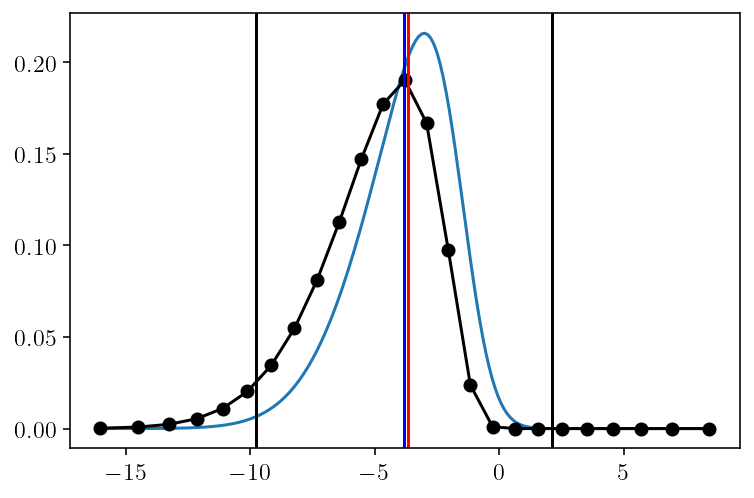

In [41]:
Asd = std_dev[sig_idx, armi_idx]
Amu = x_max[0, sig_idx, armi_idx]
def skew_norm(xs):
    unit_xs = (xs - Amu) / Asd
    return scipy.stats.skewnorm.pdf((unit_xs - xi) / w, a) / (w * Asd)
arm_xs = arm_cx[armi_idx,:,0,sig_idx]
xs = np.linspace(np.min(arm_xs), np.max(arm_xs), 200)
plt.plot(xs, skew_norm(xs))
plt.plot(arm_xs, arm_post[armi_idx,:,0,sig_idx], 'k-o')
# plt.plot(xs, scipy.stats.norm.pdf(xs, loc=Amu, scale=Asd), 'r-')
plt.axvline(x=mode * Asd + Amu, color='r')
plt.axvline(x=sn_mean * Asd + Amu, color='b')
plt.axvline(x=(sn_mean - 3 * np.sqrt(sn_var)) * Asd + Amu, color='k')
plt.axvline(x=(sn_mean + 3 * np.sqrt(sn_var)) * Asd + Amu, color='k')
plt.show()

## Junk


The first snippet here is the code Alex shared with me which was derived from the paper and from digging into the R-INLA codebase. The R-INLA source for computing a skew-normal distribution can be found by searching for the constant `0.218...` as seen in the code below.

In [72]:
def log_normal_pdf(xt):
    return scipy.stats.norm.logpdf(xt)
    
def log_normal_cdf(xt):
    return scipy.stats.norm.logcdf(xt)

def log_skew_normal_pdf(z, xi, omega, a):
    xt = (z - xi) / omega
    return jnp.log(2) - jnp.log(omega) + log_normal_pdf(xt) + log_normal_cdf(a * xt)


def get_skew_normal_params(g1, g3):
    """Calculate the skew normal parameters (based on algebra in the appendix of Rue 2009)."""
    c = 4.58686951235508 * g3
    c = jnp.cbrt(c)
    assert not jnp.isnan(c).any()
    c2 = c * c
    w = (
        jnp.sqrt(jnp.pi) * jnp.sqrt(jnp.pi * c2**2 + 2 * (jnp.pi - 4) * c2 + jnp.pi)
        + jnp.pi * (c2 - 1)
    ) / (2 * (jnp.pi - 2) * c2)
    w = jnp.sqrt(w)
    assert not jnp.isnan(w).any()
    a = w * c
    d = a / jnp.sqrt(1 + a * a)
    assert not jnp.isnan(d).any()
    e = g1 - (w * d * jnp.sqrt(2 / jnp.pi))
    return e, w, a

def SQR(x):
    return x * x

def get_skew_normal_params2(deriv_log_dens_cond, third_order_derivative):
    """Calculate the skew normal parameters (based on R-INLA)."""
    a_sigma = jnp.cbrt(third_order_derivative / 0.2180136141449902)
    cc = 1.0 / a_sigma
    sol1 = GMRFLib_2order_poleq(SQR(cc) * (1.0 - 2.0 / jnp.pi), SQR(cc) - 1.0, -1.0)
    alpha = jnp.sqrt(sol1) * (1.0 if third_order_derivative > 0.0 else -1.0)
    aa = alpha
    tmp = 1.0 / (1.0 - (2.0 / jnp.pi) * SQR(aa) / (1.0 + SQR(aa)))
    if tmp > 0.0:
        omega = jnp.sqrt(tmp)
        xi = -deriv_log_dens_cond - omega * jnp.sqrt(2.0 / jnp.pi) * aa / jnp.sqrt(
            1.0 + SQR(aa)
        )
    return alpha, omega, xi

def GMRFLib_2order_poleq(a, b, c):
    # /*
    #  * solve the equation a*x^2 + b*x + c,
    #  *
    #  * return the two solutions in sol1 and sol2. return GMRFLib_EMISC if there is complex solutions.
    #  */

    tmp = SQR(b) - 4.0 * a * c

    assert tmp > 0.0

    if a == 0:
        sol1 = -c / b
    else:
        sol1 = (-b + jnp.sqrt(tmp)) / (2.0 * a)
    return sol1

Alex's version produces almost the same output as the R-INLA version. There's a slight error in Alex's `alpha` calculation. But, above, in my code, you can see this has been corrected.

In [74]:
get_skew_normal_params(tgamma1, tgamma3), get_skew_normal_params2(tgamma1, tgamma3)

((DeviceArray(1.16449315, dtype=float64),
  DeviceArray(1.5203765, dtype=float64),
  DeviceArray(-2.8627957, dtype=float64)),
 (DeviceArray(-2.8627957, dtype=float64),
  DeviceArray(1.5203765, dtype=float64),
  DeviceArray(1.12596069, dtype=float64)))

In [75]:
a, w, xi

(-2.862795697022681,
 1.5203764991632924,
 DeviceArray(1.16449315, dtype=float64))

In [ ]:
def lj_f0(x, params, data, i):
    p_theta = params['theta'].at[i].set(x)
    return lj_f(dict(sig2 = params['sig2'], theta=p_theta), data)

d3_f = jax.jit(jax.vmap(jax.grad(jax.grad(jax.grad(lj_f0))), in_axes=(0, None, None, None)), static_argnums=(3,))
# xs = np.linspace(-10, 1, 30)
# for i in range(1):
#     d3 = d3_f(xs, params, data, i)
#     plt.plot(xs, d3)
#     plt.show()

In [1]:
import scipy.special
logit_p1 = scipy.special.logit(0.3)
def log_datal(params, data):
    return jnp.sum(
        dist.BinomialLogits(
            params["theta"] + logit_p1, total_count=data[..., 1]
        ).log_prob(data[..., 0])
    )
def ldatal_f0(x, params, data, i):
    p_theta = params['theta'].at[i].set(x)
    return log_datal(dict(sig2 = params['sig2'], theta=p_theta), data)
d3_f2 = jax.jit(jax.vmap(jax.grad(jax.grad(jax.grad(ldatal_f0))), in_axes=(0, None, None, None)), static_argnums=(3,))
xs = np.linspace(-10, 1, 30)
# for i in range(1):
#     d3 = d3_f(xs, params, data, i)
#     d32 = d3_f(xs, params, data, i)
#     plt.plot(xs, d3)
#     plt.plot(xs, d32)
#     plt.show()

NameError: name 'jax' is not defined